# day19: Kernels for Regression and Classification

Academic Credit: Prof. Hughes thanks Prof. Dan Sheldon of UMass Amherst, who released an early version of this material as "12-demo.ipynb"

Source: https://people.cs.umass.edu/~sheldon/teaching/cs335/


# Objectives

* Understand using kernels for:
* -- Linear regression
* -- Logistic regression classifiers
* -- SVM classifiers

* Get to know the squared exponential (SE) kernel
* -- aka the RBF kernel
* -- how to set its hyperparameter $\gamma$ (controls how fast the similiarity function decays around its peak)

# Outline

* [Part 1: The kernel view of regression](#part1)
* [Part 2: Squared exponential kernels](#part2)
* [Part 3: SE kernels for regression](#part3)
* [Part 4: SE kernels for binary classification with logistic regression](#part4)
* [Part 5: SE kernels for binary classification with SVMs](#part5)

# Takeaways

* Kernel methods are powerful ways to learn non-linear regression/classification methods
* The hyperparameter $\gamma$ controls model complexity. Should select via grid search on validation set.


In [1]:
import numpy as np
import pandas as pd

In [2]:
import sklearn.linear_model
import sklearn.svm
import sklearn.kernel_ridge

In [3]:
# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

In [4]:
import matplotlib.colors as mcolors

# Setup: Create Small Regression Problem

Setup a regression task with 1-dim features, which requires non-trivial features.


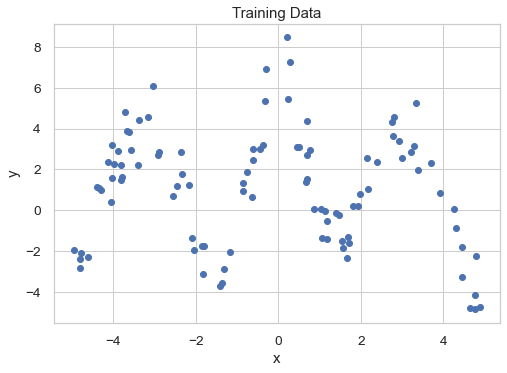

In [5]:
random_state = np.random.RandomState(0)

# Create N training x values between -5 and 5
N = 100
x_train_N = random_state.rand(N) * 10 - 5
x_train_N1 = x_train_N.reshape((N,1))
# Create evenly spaced test x values (for plotting)
L = 505
x_test_L  = np.linspace(-6, 6, L)
x_test_L1 = x_test_L.reshape((L,1))
# Determine 'true' function
def f(x):
    return 0.5*np.cos(x) + np.sin(x) + 4*np.cos(2*x) + np.exp(np.cos(3*x))

# Draw realized values of the output y: function plus noise
y_train_N = f(x_train_N) + random_state.randn(N)

# Plot the training data
plt.scatter(x_train_N, y_train_N)
plt.title('Training Data')
plt.xlabel('x');
plt.ylabel('y');

### Setup: Utility function to plot predictions for a provided model

In [6]:
def plot_model_predictions_with_train_data(clf, x_test_L1):
    ''' Plot predictions and training data in one plot.

    Note: uses global variables:
    * x_train_N, y_train_N
    * x_test_L
    Do not overwrite these variables.
    '''
    yhat_test_L = clf.predict(x_test_L1)
    plt.scatter(x_train_N, y_train_N)

    plt.plot(x_test_L, yhat_test_L, 'r-', markersize=4) # show original features and outputs
    plt.ylim([-5, 10]);
    plt.ylim([-7, 7]);
    
    plt.legend(['Test Predictions', 'Train'], bbox_to_anchor=(1.0, 0.5))

# Review: Linear Regression

We'll assume feature vectors  $x \in \mathbf{R}^G$ include a bias feature. The size of each vector $x$ is $G$.

Prediction:

$$
\hat{y}(x_*, \theta)  = \theta^T x_*
$$

Training:

$$
\min_{\theta \in \mathbb{R}^G} \quad \sum_{n=1}^N (y_n - \hat{y}(x_n, \theta) )^2
$$

which in vectorized form, is equivalent to:

$$
\min_{\theta \in \mathbb{R}^G} \quad (\mathbf{y} - \mathbf{X} \theta)^T  (\mathbf{y} - \mathbf{X} \theta)
$$


See the predictions of linear regression on our example dataset.

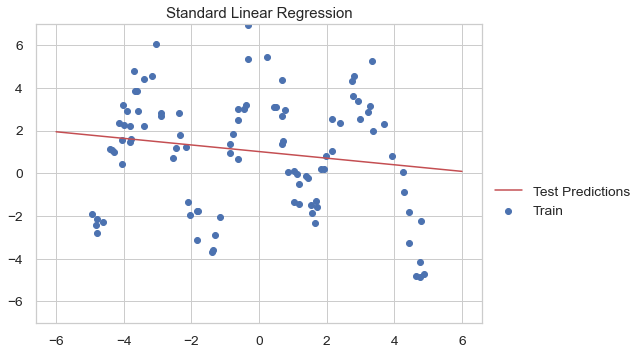

In [7]:
lr = sklearn.linear_model.LinearRegression()
lr.fit(x_train_N1, y_train_N)
plot_model_predictions_with_train_data(lr, x_test_L1)
plt.title('Standard Linear Regression');

# Part 1: Kernels for Linear Regression


Suppose our optimal linear regression weight parameters $\theta$ (the ones that minimize mean-squared error) can be rewritten as a linear combination of the feature vectors:

$\theta = \sum_{n=1}^N \alpha_n x_n$.

Then we have our predicted regression output $\hat{y}(x_*)$ at a specific test feature $x_*$ can be written as:

$$
\hat{y}(x_*, \theta)  = \theta^T x = \sum_{n=1}^N \alpha_n x_n^T x_* = \sum_{n=1}^N \alpha_n k(x_n, x_*)
$$

where $k(x,z) := x^T z$, the "kernel function", computes the dot product between feature vectors $x$ and $z$.

We can rewrite our predicted regression output as a function of $\alpha$:
$$
\hat{y}(x_*, \alpha)  = \sum_{n=1}^N \alpha_n k(x_n, x_*) = \alpha^T \mathbf{k}(x_*)
$$

where $\alpha$ is a $N$-length column vector:
$$
\begin{aligned}
\alpha &= \begin{bmatrix}\alpha_1, \ldots, \alpha_N\end{bmatrix}^T \\
\end{aligned}
$$

and $\mathbf{k}(x_*)$ is an $N$-length column vector evaluating the kernel at our test feature $x_*$ and each of the $N$ training features.

\begin{aligned}
 \mathbf{k}(x_*) &= \begin{bmatrix} k(x_1, x_*), & k(x_2, x_*), & \ldots, & k(x_N, x_*)\end{bmatrix}^T
\end{aligned}






#### Insight: An alternative parameterization

We can think this as a new linear regression problem:

\begin{aligned}
\min_{\alpha \in \mathbb{R}^N} \quad \sum_{n=1}^N (y_n - \hat{y}(x_n, \alpha) )^2 
\end{aligned}
with parameter vector $\alpha$ and a feature mapping that maps each $x$ to the vector $\mathbf{k}(x)$ of kernel comparisons between $x$ and every training point. 

If our assumption holds that the *best* $\theta$ (the one that achieves minimum cost) can be expressed as a linear combination of feature vectors, then there is some choice for the parameter vector $\alpha$ that will yield this best hypothesis. So, it suffices to look values of $\alpha$ that minimize the squared error in this new linear regression problem. That is, we can simply solve the new linear regression problem!

Taking this route, let's rewrite our sum of squared errors training loss via matrix arithmetic:

\begin{aligned}
\sum_{n=1}^N (y_n - \hat{y}(x_n, \alpha) )^2 &= (\mathbf{y} - \mathbf{K} \alpha)^T (\mathbf{y} - \mathbf{K} \alpha)
\end{aligned}

where we replace the data matrix by the kernel matrix: $\mathbf{K}$ is a $N \times N$ matrix where the $n$-th row is the vector $\mathbf{k}(x_n)$ evaluating the kernel between $x_n$ and all $N$ training points (including itself).

This is exactly our "standard" linear regression problem, with the following correspondences:

* training set output vector $y$ unchanged
* training set inputs array $X$ replaced by our kernel matrix $\mathbf{K}$
* parameters $\theta$ replaced by parameters $\alpha \in \mathbb{R}^N$

*Practical Note*: This is not generally how we always solve for $\alpha$ in practice. More efficient methods exist.

However, it is concrete proof that we can solve the learning and prediction problems while only accessing the data (feature vectors) through dot products.


Let's try it!

### Demo: Kernel Regression with Linear Kernel

Remember that a *linear* kernel is the one that recovers our desired condition that equates our $\alpha$ parameterization and our $\theta$ parameterization.

That is, we only get:
$$
\hat{y}(x_*, \theta) = \theta^T x_* = \sum_{n=1}^N \alpha_n k(x_n, x_* ) = \hat{y}(x_*, \alpha)
$$

when we have defined our kernel function as the *linear* kernel:
$$
k(x, z) = x^T z
$$

Let's try our proposed *kernelized* linear regression with this linear kernel.

In [8]:
def linear_kernel(x_NG, z_MG):
    ''' Compute dot product between each row of X and each row of Z
    
    Returns
    -------
    k_NM : 2D array
        Entry n, m is the kernel(x_NG[n], z_MG[m])
    '''
    N, G = x_NG.shape
    M, _ = z_MG.shape
    k_NM = np.zeros((N, M))
    for n in range(N):
        for m in range(M):
            k_NM[n,m] = np.dot(x_NG[n], z_MG[m])
    return k_NM

# Create version of our features with added bias
x_train_N2 = np.hstack([x_train_N1, np.ones((N,1))])
x_test_L2 = np.hstack([x_test_L1, np.ones((L,1))])

print("Remember, N = %d and L = %d" % (N, L))
print("Each feature has G=%d entries" % x_train_N2.shape[1])

k_train_NN = linear_kernel(x_train_N2, x_train_N2) + 1e-10 * np.eye(N)  # (*) see note below
print("Shape of k_train_NN: %s" % str(k_train_NN.shape))

k_test_LN  = linear_kernel(x_test_L2,  x_train_N2)
print("Shape of k_test_LN: %s" % str(k_test_LN.shape))

Remember, N = 100 and L = 505
Each feature has G=2 entries
Shape of k_train_NN: (100, 100)
Shape of k_test_LN: (505, 100)


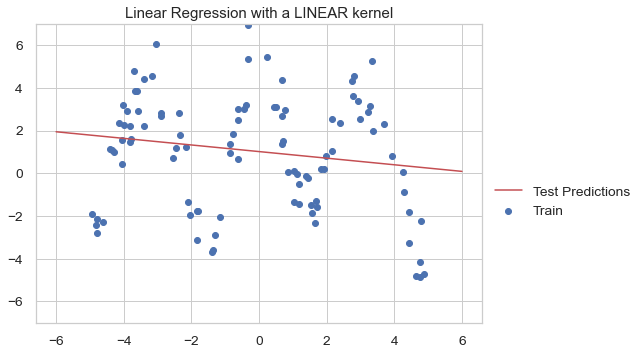

In [9]:
klr = sklearn.linear_model.LinearRegression()
klr.fit(k_train_NN, y_train_N) # Use NxN kernel array as training features
plot_model_predictions_with_train_data(klr, k_test_LN) # Use LxN kernel array as test features
plt.title('Linear Regression with a LINEAR kernel');

### Discussion 1b: How does this plot compare to our original linear regression plot?

it's the same

### Discussion 1c: Is the standard or kernelized formulation more efficient for this dataset?

Remember that we have here G=2 features (including bias) and N=100 training examples.

What is the runtime complexity of *prediction* for thie standard LR model?

What is the runtime complexity of *prediction* for the kernelized LR model?

in this case LR is more efficient than the kernelized one, because G is not bigger than N... see slide 19

### Exercise (Advanced): Why did we need the small diagonal element added to our training array in line (^)?

Try out the code above without the small positive diagonal added to k_train_NN.

What happens?

In [10]:
# TODO comment out the np.eye term in line marked  (^) above, and remake the plot
k_train_NN = linear_kernel(x_train_N2, x_train_N2) # + 1e-10 * np.eye(N)
print("Shape of k_train_NN: %s" % str(k_train_NN.shape))

Shape of k_train_NN: (100, 100)


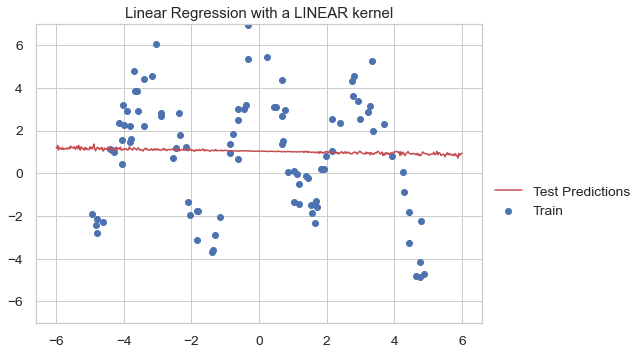

In [11]:
klr = sklearn.linear_model.LinearRegression()
klr.fit(k_train_NN, y_train_N) # Use NxN kernel array as training features
plot_model_predictions_with_train_data(klr, k_test_LN) # Use LxN kernel array as test features
plt.title('Linear Regression with a LINEAR kernel');

*Explanation*: This small positive constant is added for numerical stability. Without it, we see that the predictions are slightly *off*. 

The ultimate reason is that there might be *many* different vectors $\alpha$ that achieve low squared error cost, and thus we might recover one that is *close* to but not exactly equivalent to our original $\theta$ regression weights.

However, if we instead add even a tiny positive mass to our training matrix's diagonal, we ensure it is strictly positive definite, and we are guaranteed to exactly recover $\theta^*$. This is a result due to the *representer* theorem, see <https://en.wikipedia.org/wiki/Representer_theorem>

In [12]:
# explanation, if we take out those values from the diagonal of A, when we do optimization, we 
# have to solve Ax=b, and so if A is ill conditioned (its determinant is close to 0), we cannot do the
# inverse of A

# ALSO, doing linear transformations to the function we optimize does not change the arguments that result from the optimization
# only the min.

# Part 2: Understanding the Squared Exponential kernel

The *squared exponential* kernel for two input vectors $x \in \mathbb{R}^G$ and $z \in \mathbb{R}^G$ is given by:
$$
k_{SE}(\mathbf{x}, \mathbf{z}) = \exp (- \gamma \sum_{g=1}^G (x_g - z_g)^2)
$$

Intepret as *similarity function*.

* Equal to 1 when two input vectors are equal: $\mathbf{x} = \mathbf{z}$
* Decays exponentially as $\mathbf{z}$ and $\mathbf{x}$ get farther apart
* Hyperparameter $\gamma$ controls the *decay* of the function:
* -- Smaller $\gamma$ -> slower decay from the peak, further apart values look more similar
* -- Larger $\gamma$ -> faster decay from the peak

This is also often called the radial basis function (RBF) kernel. You can find it in sklearn as `sklearn.metrics.pairwise.rbf_kernel`.


### Plot kernel for single feature vectors at various decay hyperparameter values

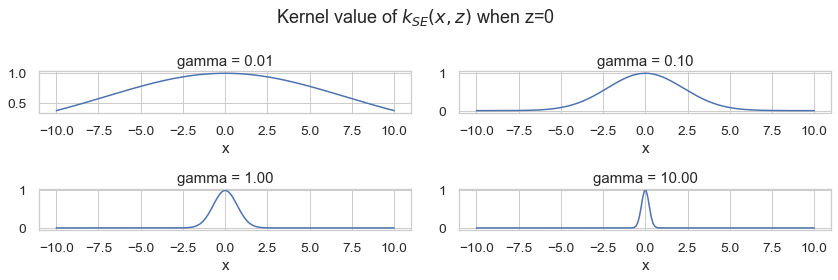

In [14]:
gamma_vals = [0.01, 0.1, 1, 10]
n_plots = len(gamma_vals)

x = np.linspace(-10, 10, 200).reshape(-1,1)

z = np.array([[0]]) # Fix z to zero


plt.figure(figsize=(12, 4))
for i in range(n_plots):
    plt.subplot(2, 2, i+1)
    k = sklearn.metrics.pairwise.rbf_kernel(x, z, gamma=gamma_vals[i]) # fixed error. passed not zero but z.
    plt.plot(x, k)
    plt.title('gamma = %.2f' % (gamma_vals[i]))
    plt.xlabel('x')
plt.suptitle("Kernel value of $k_{SE}(x, z)$ when z=%.3g" % z)
plt.tight_layout()
plt.show()

## Exercise 2a: Remake this plot above with z=+3. 

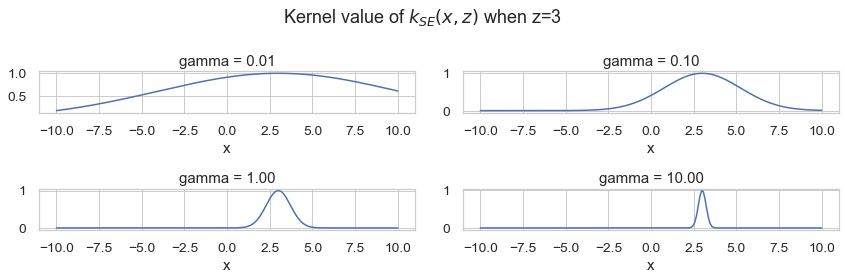

In [15]:
gamma_vals = [0.01, 0.1, 1, 10]
n_plots = len(gamma_vals)

M = 200
x_M1 = np.linspace(-10, 10, M).reshape((M,1))
z_11 = np.array([[3.0]])#3.0 # TODO fix to z to be a 1x1 array with value 3.0

plt.figure(figsize=(12, 4))
for i in range(n_plots):
    plt.subplot(2, 2, i+1)
    # TODO compute the kernel between each entry of array x_M1 and our z value z_11
    k_M = sklearn.metrics.pairwise.rbf_kernel(x_M1, z_11, gamma=gamma_vals[i])
    plt.plot(x_M1, k_M)
    plt.title('gamma = %.2f' % (gamma_vals[i]))
    plt.xlabel('x')
plt.suptitle("Kernel value of $k_{SE}(x, z)$ when z=%.3g" % z_11)
plt.tight_layout()
plt.show()

# Part 3: Using the SE kernel for Kernel Regression

### SE kernel regression with decay parameter 3.0

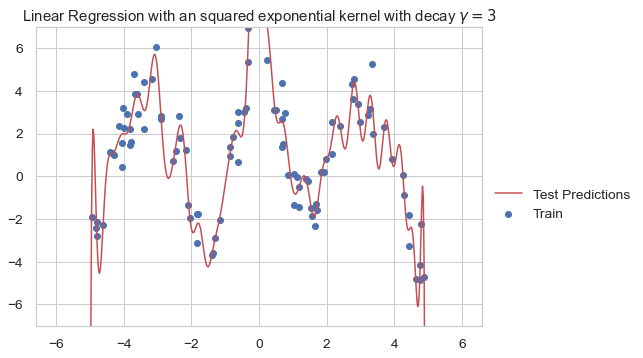

In [16]:
gamma = 3.0

# Matrix of similarities between training points
k_train_NN = sklearn.metrics.pairwise.rbf_kernel(x_train_N1, x_train_N1, gamma=gamma) + 1e-8 * np.eye(N)

# ith row = similarity of ith test point to all training points
k_test_LN  = sklearn.metrics.pairwise.rbf_kernel(x_test_L1,  x_train_N1, gamma=gamma) 

klr = sklearn.linear_model.LinearRegression()
klr.fit(k_train_NN, y_train_N)
plot_model_predictions_with_train_data(klr, k_test_LN)
plt.title('Linear Regression with an squared exponential kernel with decay $\gamma = %g$' % gamma);

### SE kernel regression with decay parameter 1.0

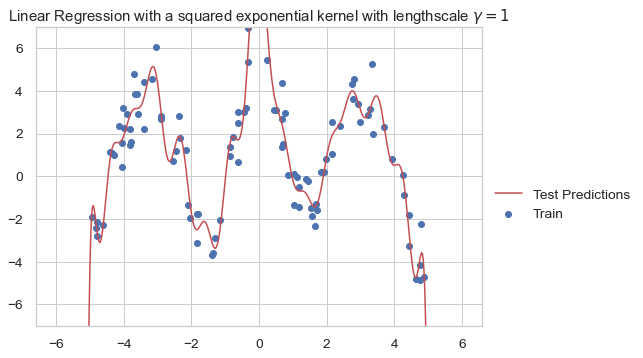

In [17]:
gamma = 1.0

# Matrix of similarities between training points
k_train_NN = sklearn.metrics.pairwise.rbf_kernel(x_train_N1, x_train_N1, gamma=gamma) + 1e-8 * np.eye(N)

# ith row = similarity of ith test point to all training points
k_test_LN  = sklearn.metrics.pairwise.rbf_kernel(x_test_L1,  x_train_N1, gamma=gamma) 

klr = sklearn.linear_model.LinearRegression()
klr.fit(k_train_NN, y_train_N)
plot_model_predictions_with_train_data(klr, k_test_LN)
plt.title('Linear Regression with a squared exponential kernel with lengthscale $\gamma = %g$' % gamma);

### SE kernel regression with decay parameter 1/3

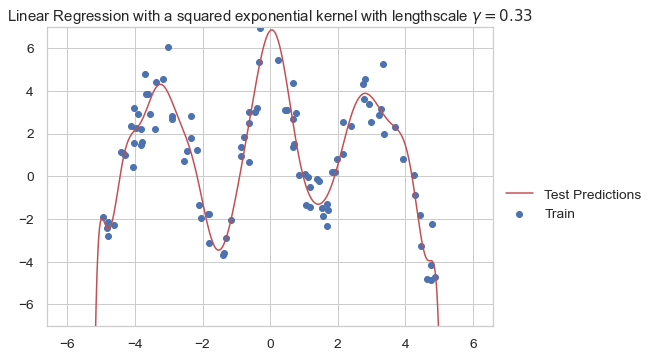

In [18]:
gamma = 0.33

# Matrix of similarities between training points
k_train_NN = sklearn.metrics.pairwise.rbf_kernel(x_train_N1, x_train_N1, gamma=gamma) + 1e-8 * np.eye(N)

# ith row = similarity of ith test point to all training points
k_test_LN  = sklearn.metrics.pairwise.rbf_kernel(x_test_L1,  x_train_N1, gamma=gamma) 

klr = sklearn.linear_model.LinearRegression()
klr.fit(k_train_NN, y_train_N)
plot_model_predictions_with_train_data(klr, k_test_LN)
plt.title('Linear Regression with a squared exponential kernel with lengthscale $\gamma = %g$' % gamma);

### Discussion 3a: What happens to the predicted functions above as we decrease gamma? why?

TODO discuss and respond. It tends to overfit less as we're decreasing gamma.

### Exercise 3b: Repeat to make the plot with decay parameter gamma = 0.05.

Can you make the predicted function look even smoother?

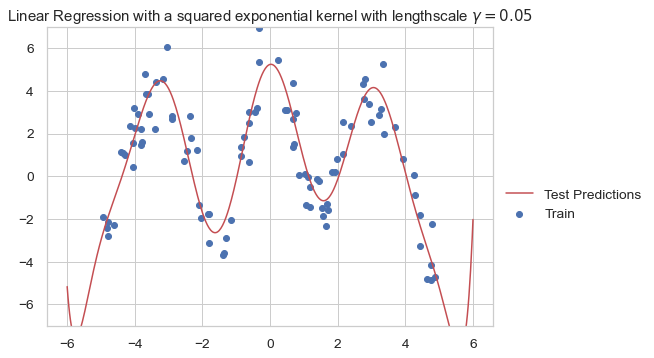

In [19]:
gamma = 0.05

# Matrix of similarities between training points
k_train_NN = sklearn.metrics.pairwise.rbf_kernel(x_train_N1, x_train_N1, gamma=gamma) + 1e-8 * np.eye(N) # TODO

# Matrix of similarities between test points and training points
# ith row = similarity of ith test point to all training points
k_test_LN  = sklearn.metrics.pairwise.rbf_kernel(x_test_L1,  x_train_N1, gamma=gamma) # TODO

klr = sklearn.linear_model.LinearRegression()
klr.fit(k_train_NN, y_train_N)
plot_model_predictions_with_train_data(klr, k_test_LN)
plt.title('Linear Regression with a squared exponential kernel with lengthscale $\gamma = %g$' % gamma);

# Setup for Parts 4 and 5: Classification with Kernels

Again, credit for this example goes to Dan Sheldon (see links above).

Can we show that kernels are useful for *classification* too?

In [20]:
N = 300  # number of points per class
D = 2   # dimensionality
K = 2   # number of classes

x_tr_ND = np.zeros((N*K,D)) # data matrix (each row = single example)
y_tr_N = np.zeros(N*K) # class labels

# Generate spiral toy data
random_state = np.random.RandomState(101)
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + random_state.randn(N)*0.4 # theta
    x_tr_ND[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y_tr_N[ix] = j


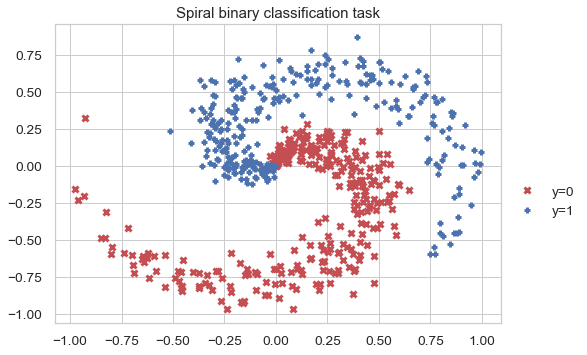

In [21]:
# Visualize the data
plt.plot(x_tr_ND[y_tr_N==0, 0], x_tr_ND[y_tr_N==0, 1], 'rx', label='y=0', mew=3)
plt.plot(x_tr_ND[y_tr_N==1, 0], x_tr_ND[y_tr_N==1, 1], 'b+', label='y=1', mew=3)
plt.legend(bbox_to_anchor=(1.0, 0.5));
plt.title("Spiral binary classification task");

In [22]:
def plot_pretty_decision_boundaries_for_clf(
        x1_GH, x2_GH, f_GH,
        do_show_colorbar=False,
        x1_ticks=np.asarray([-1, 0, 1]),
        x2_ticks=np.asarray([-1, 0, 1]),
        c_levels=np.linspace(-2, 2, 200),
        c_ticks=np.asarray([-1.0, 0.0, 1.0])):
    cur_ax = plt.gca()

    # Prepare a colormap that shows the margin between -1 and +1 predicted function values well
    B = 0.2
    red_to_blue_colors = plt.cm.RdYlBu(np.linspace(2.5*B, 1-B, 50))
    red_colors = plt.cm.RdYlBu(np.linspace(0.0, 2.5*B, 100))
    blue_colors = plt.cm.RdYlBu(np.linspace(1-B, 1.0, 50))
    colors = np.vstack((red_colors, red_to_blue_colors, blue_colors))
    mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
    
    # Plot contours of f as function of x1 and x2
    # Only show between -2 and +2 so margin is visible
    f_GH = np.maximum(np.minimum(f_GH, c_levels[-1]), c_levels[0])
    my_contourf_h = plt.contourf(
        x1_GH, x2_GH, f_GH, levels=c_levels,
        vmin=c_levels[0], vmax=c_levels[-1], cmap=mymap)
    plt.xticks(x1_ticks, x1_ticks);
    plt.yticks(x2_ticks, x2_ticks);
    
    if do_show_colorbar:
        left, bottom, width, height = plt.gca().get_position().bounds
        cax = plt.gcf().add_axes([left+1.1*width, bottom, 0.03, height])
        plt.colorbar(my_contourf_h, orientation='vertical', cax=cax, ticks=c_ticks);
        plt.sca(cur_ax);

### Setup: Create dense grid of possiple x inputs for test

In [23]:
# Get regular grid of x test points that is G x H
# Each point is an (x1, x2) location
x1_grid=np.linspace(-1.5, 1.5, 301)
x2_grid=np.linspace(-1.5, 1.5, 301)
G = x1_grid.size
H = x2_grid.size
x1_GH, x2_GH = np.meshgrid(x1_grid, x2_grid)   

L = G * H
x_test_LD = np.hstack([x1_GH.flatten()[:,np.newaxis], x2_GH.flatten()[:,np.newaxis]])

print("Shape of x_test_LD is %s" % str(x_test_LD.shape))

Shape of x_test_LD is (90601, 2)


# Part 4: Logistic Regression with SE kernels

We'll try here to see how well logistic regression does with various hyperparameters $\gamma$.

Remember, we're visualizing the real-valued *score* of each input, before it is fed into sigmoid to become a probability.

### LR with gamma = 3

/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


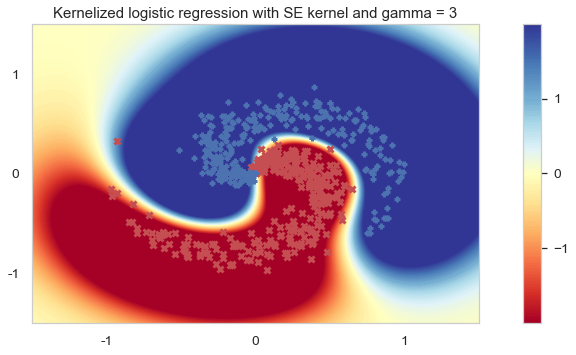

In [24]:
gamma = 3

k_tr_NN = sklearn.metrics.pairwise.rbf_kernel(x_tr_ND, x_tr_ND, gamma=gamma)

clf = sklearn.linear_model.LogisticRegression(solver='lbfgs', C=1.0)
clf.fit(k_tr_NN, y_tr_N)


k_te_LN = sklearn.metrics.pairwise.rbf_kernel(x_test_LD, x_tr_ND, gamma=gamma)

alpha_N = clf.coef_[0]
fhat_L = np.dot(k_te_LN, alpha_N)

plot_pretty_decision_boundaries_for_clf(x1_GH, x2_GH, fhat_L.reshape((G,H)), do_show_colorbar=True)
plt.plot(x_tr_ND[y_tr_N==0, 0], x_tr_ND[y_tr_N==0, 1], 'rx', mew=3);
plt.plot(x_tr_ND[y_tr_N==1, 0], x_tr_ND[y_tr_N==1, 1], 'b+', mew=3);
plt.title("Kernelized logistic regression with SE kernel and gamma = %g" % gamma);

### LR with gamma = 100

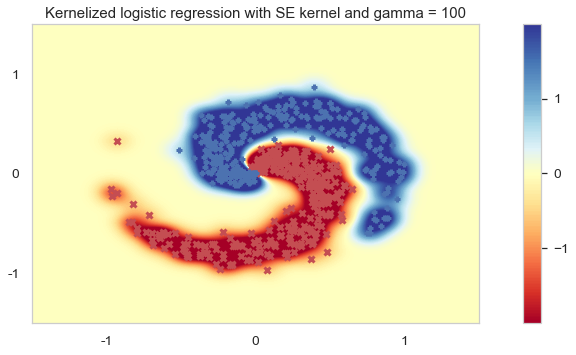

In [175]:
gamma = 100

k_tr_NN = sklearn.metrics.pairwise.rbf_kernel(x_tr_ND, x_tr_ND, gamma=gamma)

clf = sklearn.linear_model.LogisticRegression(solver='lbfgs', C=1.0)
clf.fit(k_tr_NN, y_tr_N)


k_te_LN = sklearn.metrics.pairwise.rbf_kernel(x_test_LD, x_tr_ND, gamma=gamma)

alpha_N = clf.coef_[0]
fhat_L = np.dot(k_te_LN, alpha_N)

plot_pretty_decision_boundaries_for_clf(x1_GH, x2_GH, fhat_L.reshape((G,H)), do_show_colorbar=True)
plt.plot(x_tr_ND[y_tr_N==0, 0], x_tr_ND[y_tr_N==0, 1], 'rx', mew=3);
plt.plot(x_tr_ND[y_tr_N==1, 0], x_tr_ND[y_tr_N==1, 1], 'b+', mew=3);
plt.title("Kernelized logistic regression with SE kernel and gamma = %g" % gamma);

### Exercise 4a: Try a few more values for gamma. What is the "optimal" one to you (by inspecting the plot)?

# Part 5: Kernels and SVMs

Remember, we're visualizing the real-valued *score* of each input, before it is fed into sigmoid to become a probability.

### SVM with SE kernel and gamma = 3

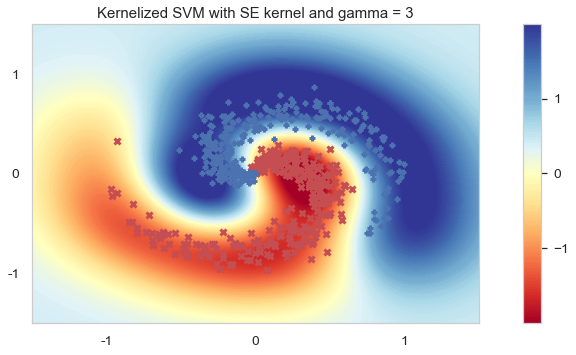

In [25]:
gamma = 3

clf = sklearn.svm.SVC(C=1.0, kernel='rbf', gamma=gamma)
clf.fit(x_tr_ND, y_tr_N)

# Easy way to compute w * x + b
fhat_L = clf.decision_function(x_test_LD)

plot_pretty_decision_boundaries_for_clf(x1_GH, x2_GH, fhat_L.reshape((G,H)), do_show_colorbar=True)
plt.plot(x_tr_ND[y_tr_N==0, 0], x_tr_ND[y_tr_N==0, 1], 'rx', mew=3);
plt.plot(x_tr_ND[y_tr_N==1, 0], x_tr_ND[y_tr_N==1, 1], 'b+', mew=3);
plt.title("Kernelized SVM with SE kernel and gamma = %g" % gamma);

### SVM with SE kernel and gamma = 100

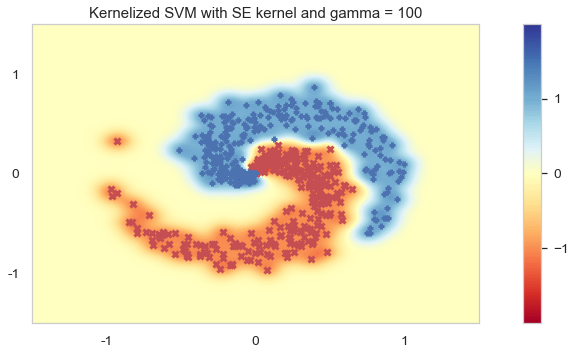

In [26]:
gamma = 100

clf = sklearn.svm.SVC(C=1.0, kernel='rbf', gamma=gamma)
clf.fit(x_tr_ND, y_tr_N)

# Easy way to compute w * x + b
fhat_L = clf.decision_function(x_test_LD)

plot_pretty_decision_boundaries_for_clf(x1_GH, x2_GH, fhat_L.reshape((G,H)), do_show_colorbar=True)
plt.plot(x_tr_ND[y_tr_N==0, 0], x_tr_ND[y_tr_N==0, 1], 'rx', mew=3);
plt.plot(x_tr_ND[y_tr_N==1, 0], x_tr_ND[y_tr_N==1, 1], 'b+', mew=3);
plt.title("Kernelized SVM with SE kernel and gamma = %g" % gamma);

### Discussion 5a: Do you see any major differences in the visual plots between SVMs (4a, 4b) and LR (3a, 3b)?

TODO discuss

### Discussion 5b: Talk about how we used code to *train* the logistic regression vs the SVM.

* Why do we need to call LR's fit method with a kernel matrix we need to create?
* Why can we just call SVM's fit method with the x array?

TODO discuss

### Exercise 5c: Try a few more values for gamma. What is the "optimal" one for this training set (when using SVMs)?

TODO

### Exercise 5d: Above, we fixed C = 1.0. Should we also pick this value to deliver best performance?

Why or why not?